In [92]:
import matplotlib as mpl
import os, sys
mpl.use('Agg')
from LiteNet import *
import tensorflow as tf
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from time import time
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

In [2]:
from nystrom_kexpfam.data_generators.Gaussian import GaussianGridWrapped
from nystrom_kexpfam.data_generators.Ring import Ring
#from nystrom_kexpfam.data_generators.Dataset import GlassPosteriorDataset

from nystrom_kexpfam.log import logger
from nystrom_kexpfam.visualisation import visualise_array_2d

from nystrom_kexpfam.estimators.KMCLite import KMCLite

INFO: 2018-04-27 20:30:02,704: log.<module>(): Global logger initialised with loglevel 20
INFO: 2018-04-27 20:30:02,808: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handl

In [3]:
D = 2
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)
def gen_data(n):
    
    # random uniform
    # rand_data1 = np.c_[np.random.uniform(-6,2,n/2), np.random.uniform(-7,-2,n/2)]
    # rand_data2 = np.c_[np.random.uniform(2,7,n/2) , np.random.uniform(-2,6,n/2)]
    # rand_data  = np.r_[rand_data1, rand_data2]

    # gaussian mixture
    #rand_data1  = np.random.randn(n/2,2)*3-3
    #rand_data2  = np.random.randn(n/2,2)*3+3
    #rand_data  = np.r_[rand_data1, rand_data2]
    
    # full cov gaussian
    #rand_data  = np.random.randn(n,D)*np.sqrt(2)
    
    # fixed grid
    # rand_data = np.array([[xv,yv] for xv in np.linspace(-6,2,50) for yv in np.linspace(-7,-2,50)])
    # rand_data = np.array([[xv,yv] for xv in np.linspace(2,7,50) for yv in np.linspace(-2,6,50)])
    # rand_data = np.r_[rand_data, rand_data]
    #np.random.shuffle(rand_data)
    
    # add noise
    #rand_data += np.random.randn(*rand_data.shape)*0.2
    

    #rand_data1 = p.sample(8*n/10)
    #rand_data2 = np.c_[np.random.uniform(-5,5,2*n/10), np.random.uniform(-1,1,2*n/10)]
    #rand_data  = np.r_[rand_data1, rand_data2]
    
    rand_data = p.sample(n)
    
    return rand_data

def true_score(p, gv, train_data_val, test_data_val):
    
    ge = gv.eval(feed_dict={train_data: train_data_val, eval_points_tensor: test_data_val})
    gt = p.grad_multiple(test_data_val)
    return 0.5 * np.mean(np.sum((ge-gt)**2, 1))

def visualise_array_2d(Xs, Ys, A, samples=None, ax=None):
    # visualise found fit
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    vmin = np.nanmin(A)
    vmax = np.nanmax(A)
    heatmap = ax.pcolor(Xs, Ys, A.T, cmap='viridis', vmin=vmin, vmax=vmax)
    heatmap.cmap.set_under('white')
    
    colorbar = plt.colorbar(heatmap, ax=ax)
    colorbar.set_clim(vmin=vmin, vmax=vmax)
    
    if samples is not None:
        ax.scatter(samples[:, 0], samples[:, 1], c='r', s=1);
    

In [112]:
X, Y = np.linspace(-2,2,100, dtype="float32"), np.linspace(-6,-2,100, dtype="float32")

np.random.seed(1)

nrep = 10
ntrain =500
ntest = ntrain*10
test_batch_size = ntrain*2


sigma = tf.placeholder("float32", shape=[])
lam   = tf.placeholder("float32", shape=[])
alpha = tf.Variable(np.zeros(ntrain, dtype="float32"))
points = tf.placeholder(shape=(ntrain, D),  dtype="float32")
test_data = tf.placeholder("float32", shape=(test_batch_size, D), name="1")

kernel = GaussianKernel(sigma)

kn = KernelModel(kernel, alpha = alpha)
kn.set_points(points)
alpha_opt, _, score, train_data = kn.opt_score(lam=lam, lam2=lam)[:4]
gv = kn.evaluate_grad(test_data)

nX = len(X)
nY = len(Y)
scores = np.zeros((nrep, nX, nY))


config = tf.ConfigProto(device_count={"GPU":0})
config.gpu_options.allow_growth=True
init = tf.global_variables_initializer()


rand_train_data = gen_data(ntrain)
rand_test_data = gen_data(ntrain)


with tf.Session(config=config) as sess:
    
    sess.run(init)

    for xi, x in enumerate(tqdm(X)):
        for yi, y in enumerate(Y):

            for r in range(nrep):
                rand_train_data = gen_data(ntrain)
                feed = {train_data: rand_train_data.astype("float32"), 
                        points:rand_train_data.astype("float32"),
                        sigma: 10**(x), lam:10**(y)}
                
                sess.run(alpha_opt, feed_dict=feed)

                nbatch = ntest/test_batch_size
                
                for i in range(nbatch):
                    d = gen_data(test_batch_size)
                    feed[test_data] = d
                    gt = p.grad_multiple(d)
                    ge = gv.eval(feed_dict=feed)
                    scores[r, xi,yi] += 0.5 * np.mean(np.sum((gt-ge)**2,1))
                scores[r, xi,yi] /= nbatch
    alpha_val = alpha.eval()

Tensor("Placeholder_161:0", shape=(500, 2), dtype=float32)
Tensor("Placeholder_162:0", shape=(?, 2), dtype=float32)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [97]:
scores = np.mean(scores,0)
best_ind = np.unravel_index(np.nanargmin(scores), scores.shape)

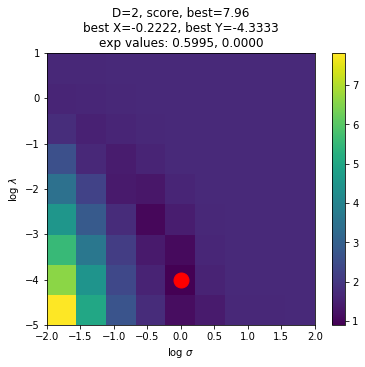

In [111]:
fig,ax = plt.subplots(figsize=(6,5))
visualise_array_2d(X, Y, np.log10(scores), ax=ax)
dX = X[1]-X[0]
dY = Y[1]-Y[0]
plt.plot(X[best_ind[0]]+dX/2, Y[best_ind[1]]+dY/2, 'ro', markersize=15)

ax.set_title("D=%d, score, best=%.2f\nbest X=%.4f, best Y=%.4f\nexp values: %.4f, %.4f" % \
                     (D, np.nanmin(scores), X[best_ind[0]], Y[best_ind[1]],
                        10**(X[best_ind[0]]), 10**(Y[best_ind[1]]))
            )
ax.set_xlabel(r"log $\sigma$" )
ax.set_ylabel(r"log $\lambda$")
fig.savefig("figs/%s_D" % )


In [24]:
npoint = 500
lam = 10**(tf.constant(-1, dtype="float32"))
lam2 = tf.identity(lam)
#lam2= 10**(tf.constant(-1, dtype="float32"))
#lam3= 10**(tf.constant(-2, dtype="float32"))
lam3 = tf.constant(0.0, dtype="float32")
sigma = 10**(tf.constant(-1, dtype="float32"))

s = 10


plot_size = 12

net_type = "i"

step_size = 3e-2
init_std = 1e-1

niter = 500

ndim = (50,)

batch_size = 500
ntrain = npoint
nval = 1000
seed = 1

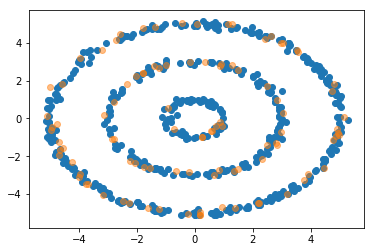

In [27]:
#np.random.seed(seed)

#rand_data_val1 = np.array([[xv,yv] for xv in np.linspace(-6,2,10) for yv in np.linspace(-7,-2,10)])
#rand_data_val2 = np.array([[xv,yv] for xv in np.linspace(2,7,10) for yv in np.linspace(-2,6,10)])
#rand_data_train = np.r_[rand_data_val1, rand_data_val2]
rand_data_train = gen_data(ntrain)
rand_points = gen_data(100)
rand_data_test  = gen_data(nval)

ndim_in = (rand_data_train.shape[1],)


np.random.shuffle(rand_data_train)
plt.scatter(rand_data_train[:,0],rand_data_train[:,1])
plt.scatter(rand_points[:,0],rand_points[:,1], alpha=0.5);

In [31]:
ngrid = 100

np.random.seed(1)

if D == 2:
    eval_points = np.array([[xv,yv] 
            for xv in np.linspace(-plot_size/2,plot_size/2,ngrid) 
                            for yv in np.linspace(-plot_size/2,plot_size/2,ngrid)])
    

print '=====building network'
if net_type=="s":
    network = LinearSoftNetwork(ndim_in, ndim, init_std=init_std)
elif net_type=="l":
    network = LinearNetwork(ndim_in, ndim[0], batch_size = batch_size, init_std=init_std, identity=False)
elif net_type=="i":
    network = None

print '=====building kernel'


print '=====building model'
if net_type != "i":
    kn = KernelNetModel(kernel, network)
else:
    kn = KernelModel(kernel)

lam = 10**(tf.constant(-1, dtype="float32"))
lam3 = tf.constant(0.0, dtype="float32")
sigma = 10**(tf.constant(-1, dtype="float32"))

kernel  = GaussianKernel(sigma)
kn.set_points(tf.constant(rand_train_data.astype("float32")))

print '=====building network'

loss, score, train_data, val_data, r_norm, l_norm, curve, alpha_assign = kn.val_score(lam=lam, lam2=lam, lam3=lam3)
init = tf.global_variables_initializer()

eval_points_tensor = tf.placeholder("float32", shape=(None, D), name="2")

gv = kn.evaluate_grad(eval_points_tensor)

with tf.Session() as sess:

    sess.run(init)

    print kn.alpha.eval(feed_dict={train_data: rand_train_data}).mean()
    gt = p.grad_multiple(rand_test_data)
    ge = gv.eval(feed_dict={train_data: rand_train_data, eval_points_tensor: rand_test_data})

    print 0.5 * np.mean(np.sum((gt-ge2)**2,1))

=====building network
=====building kernel
=====building model
=====building network
Tensor("Const_47:0", shape=(500, 2), dtype=float32)
Tensor("Placeholder_41:0", shape=(?, 2), dtype=float32)
Tensor("Const_47:0", shape=(500, 2), dtype=float32)
Tensor("Placeholder_42:0", shape=(?, 2), dtype=float32)
0.146724
42.4334473027


In [18]:
alpha_val2 = kn2.alpha.eval(feed_dict={train_data: rand_train_data})

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [30]:

#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.0)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1000)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True

sess = tf.InteractiveSession()
sess.run(init)

ValueError: No gradients provided for any variable: ['<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f3e040afb10>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f3e040af1d0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f3e040af0d0>', '<tensorflow.python.training.optimizer._RefVariableProcessor object at 0x7f3e04133c50>'].

In [54]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lams   = np.zeros(niter+1)
lam2s  = np.zeros(niter+1)
lam3s  = np.zeros(niter+1)

fvs = []
rand_data_val = gen_data(nval)
feed   = {train_data: rand_data_train,
          val_data  : rand_data_val}


init = tf.global_variables_initializer()

sess.run(init)
t0 = time()

for i in range(niter+1):

    feed[val_data] = gen_data(nval)
    #feed[train_data] = gen_data(ntrain)


    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], eval_points_tensor:eval_points})
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, alpha_val = sess.run([score, r_norm, l_norm, curve, kn.alpha], 
        feed_dict=feed)

    sigmas[i], lams[i], lam2s[i] ,lam3s[i]  = sess.run([sigma, lam, lam2, lam3])

    if i % min(100, niter/5) == 0:
        print '=================='
        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        print 'sigma: %.5f' % sigma.eval()
        print 'lam, lam2, lam3', lam.eval(), lam2.eval(), lam3.eval()
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c = ', r_norm_val, l_norm_val, curve_val


Iteration     0, score -0.169 ( -0.5), time taken 1.94
sigma: 1.05477
lam, lam2, lam3 0.0933254 0.0933255 0.00933268
alpha: 0.0081787
rn, ln, c =  1.94749 0.311043 0.093396
Iteration   100, score -46.9 ( -0.5), time taken 14.90
sigma: 0.22118
lam, lam2, lam3 0.000853392 0.00141904 0.000780858
alpha: 1.9888
rn, ln, c =  20354.5 3975.32 5525.71
Iteration   200, score -35.9 ( -0.5), time taken 27.15
sigma: 0.37872
lam, lam2, lam3 0.000299462 0.000315542 0.000959109
alpha: 2.7014
rn, ln, c =  49450.5 11566.2 4976.31
Iteration   300, score -37.9 ( -0.5), time taken 39.98
sigma: 0.40593
lam, lam2, lam3 0.000151866 0.000170169 0.00173411
alpha: 3.0254
rn, ln, c =  63987.0 19103.8 5299.18
Iteration   400, score -33.4 ( -0.5), time taken 52.09
sigma: 0.39854
lam, lam2, lam3 8.93202e-05 9.89528e-05 0.00292617
alpha: 3.045
rn, ln, c =  63665.5 27521.9 5577.16
Iteration   500, score -42.8 ( -0.5), time taken 64.96
sigma: 0.48161
lam, lam2, lam3 5.66556e-05 0.000113531 0.00255469
alpha: 3.498
rn, l

In [55]:
#rand_data_train = gen_data(500)
rand_data_test = gen_data(10000)

model score:  -41.091
true score:   9.13806256051


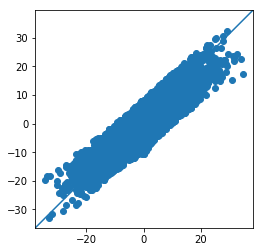

In [56]:
ge = []
sc = []
for i in range(20):
    d = rand_data_test[i*batch_size:(i+1)*batch_size]
    o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_data_train, eval_points_tensor: d, 
                                             val_data: d})
    ge += [o1]
    sc += [o2]

ge = np.concatenate(ge,0)
gt = p.grad_multiple(rand_data_test)
print "model score: ", np.mean(sc)
print "true score:  ", 0.5*np.mean(np.sum((ge-gt)**2,1))
plt.scatter(gt.flatten(), ge.flatten())
plt.axis("square");
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

model score:  -40.7502632061
true score:   9.93267280937


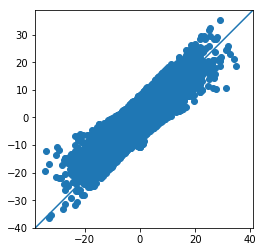

In [63]:
est = KMCLite(m = 500, sigma = np.exp(0.1224), lmbda = np.exp(-4.1224))
#rand_data_train = p.sample(500)
#rand_data_test = p.sample(5000)

est.fit(rand_data_train)

ge = est.grad(rand_data_test)
gt = p.grad_multiple(rand_data_test)

sc = []
for i in range(rand_data_test.shape[0]/rand_data_train.shape[0]):
    d = rand_data_test[i*batch_size:(i+1)*batch_size]
    sc += [est.score(d)]
print "model score: ", np.mean(sc)
print "true score:  ", 0.5*np.mean(np.sum((ge-gt)**2,1))

plt.scatter(gt.flatten(), ge.flatten());
plt.axis("square");
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

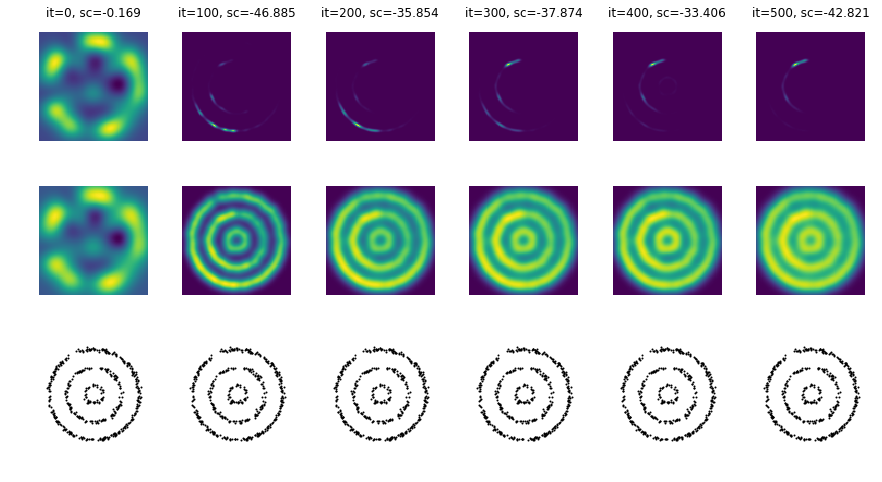

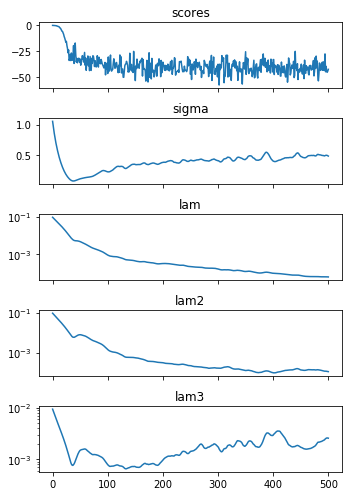

In [64]:

nfvs  = len(fvs)
fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
rand_data = (ngrid/2)+(rand_data_train*ngrid/plot_size)
vmin = min(map(np.min, fvs))
vmax = max(map(np.max, fvs))

for i in range(len(fvs)):

    iter_number = niter/5*i
    ax = axes[0, i]

    hist = (fvs[i])

    ax.imshow( hist.reshape(ngrid, ngrid).T)
    ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
    ax.set_axis_off()

    ax = axes[1, i]
    ax.imshow( np.log(hist).reshape(ngrid, ngrid).T)
    ax.set_axis_off()


    ax = axes[2, i]
    ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
    ax.set_axis_off()


#plt.show()
#fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
#fig.savefig("figs/grid_dist/test.pdf") 

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam2s)
ax.set_title("lam2")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam3s)
ax.set_title("lam3")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 

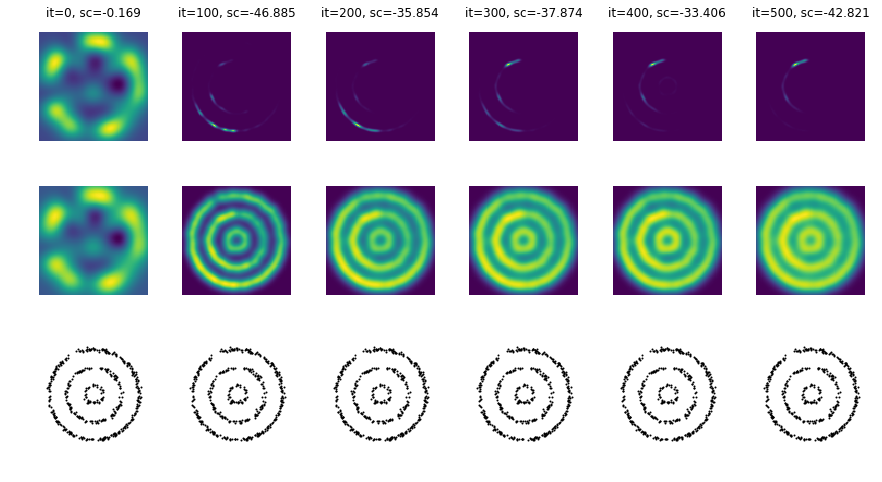

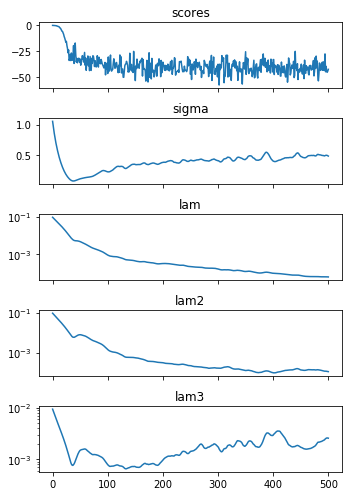

In [65]:
if D == 2:
    nfvs  = len(fvs)
    fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
    rand_data = (ngrid/2)+(rand_data_train*ngrid/plot_size)
    vmin = min(map(np.min, fvs))
    vmax = max(map(np.max, fvs))

    for i in range(len(fvs)):

        iter_number = niter/5*i
        ax = axes[0, i]
        
        hist = (fvs[i])

        ax.imshow( hist.reshape(ngrid, ngrid).T)
        ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
        ax.set_axis_off()

        ax = axes[1, i]
        ax.imshow( np.log(hist).reshape(ngrid, ngrid).T)
        ax.set_axis_off()

        
        ax = axes[2, i]
        ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1, vmin=vmin, vmax=vmax)
        ax.set_axis_off()


    #plt.show()
    #fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
    #fig.savefig("figs/grid_dist/test.pdf") 

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam2s)
ax.set_title("lam2")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam3s)
ax.set_title("lam3")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 